In [1]:
from splink.duckdb.duckdb_linker import DuckDBLinker

In [2]:
import pandas as pd 
pd.options.display.max_rows = 1000
df = pd.read_parquet("./data/historical_figures_with_errors_50k.parquet")
df.head(5)

,uncorrupted_record,cluster,full_name,dob,birth_place,postcode_fake,lat,lng,gender,occupation,unique_id
0,True,Q2296770,"thomas clifford, 1st baron clifford of chudleigh",1630-08-01,Devon,TQ13 8DF,50.692449,-3.813964,male,politician,Q2296770-1
1,False,Q2296770,thomas of chudleigh,1630-08-01,Devon,TQ13 8DF,50.692449,-3.813964,male,politician,Q2296770-2
2,False,Q2296770,tom 1st baron clifford of chudleigh,1630-08-01,Devon,TQ13 8DF,50.692449,-3.813964,male,politician,Q2296770-3
3,False,Q2296770,thomas 1st chudleigh,1630-08-01,Devon,TQ13 8HU,50.687638,-3.895877,None,politician,Q2296770-4
4,False,Q2296770,"thomas clifford, 1st baron chudleigh",1630-08-01,Devon,TQ13 8DF,50.692449,-3.813964,None,politician,Q2296770-5


In [3]:
import numpy as np
import pandas as pd

def clean_df(df):
    cols = [
        "unique_id",
        "cluster",
        "full_name",
        "dob",
        "birth_place",
        "postcode_fake",
        "gender",
        "occupation",
    ]

    df = df[cols].copy()

    df["name_split"] = df["full_name"].str.strip().str.split(" ")
    df["name_split_length"] = df["name_split"].str.len()
    df["first_name"] = df["name_split"].str[0]
    df["surname"] = df["name_split"].str[-1]
    df["surname"] = np.where(df["name_split_length"] > 1, df["surname"], "")
    # df["middle_names"] = df["name_split"].str[1:-1]

    df["first_and_surname"] = df["first_name"] + " " + df["surname"]

    for col in [
        "full_name",
        "first_and_surname",
        "first_name",
        "surname",
        "dob",
        "birth_place",
        "postcode_fake",
        "gender",
        "occupation",
    ]:
        df[col] = df[col].str.lower().str.strip()
        df[col] = df[col].replace({"": None})

    cols = [
        "unique_id",
        "cluster",
        "full_name",
        "first_and_surname",
        "first_name",
        "surname",
        "dob",
        "birth_place",
        "postcode_fake",
        "gender",
        "occupation",
    ]
    return df[cols]


df_clean = clean_df(df)
df_clean.head(2)

,unique_id,cluster,full_name,first_and_surname,first_name,surname,dob,birth_place,postcode_fake,gender,occupation
0,Q2296770-1,Q2296770,"thomas clifford, 1st baron clifford of chudleigh",thomas chudleigh,thomas,chudleigh,1630-08-01,devon,tq13 8df,male,politician
1,Q2296770-2,Q2296770,thomas of chudleigh,thomas chudleigh,thomas,chudleigh,1630-08-01,devon,tq13 8df,male,politician


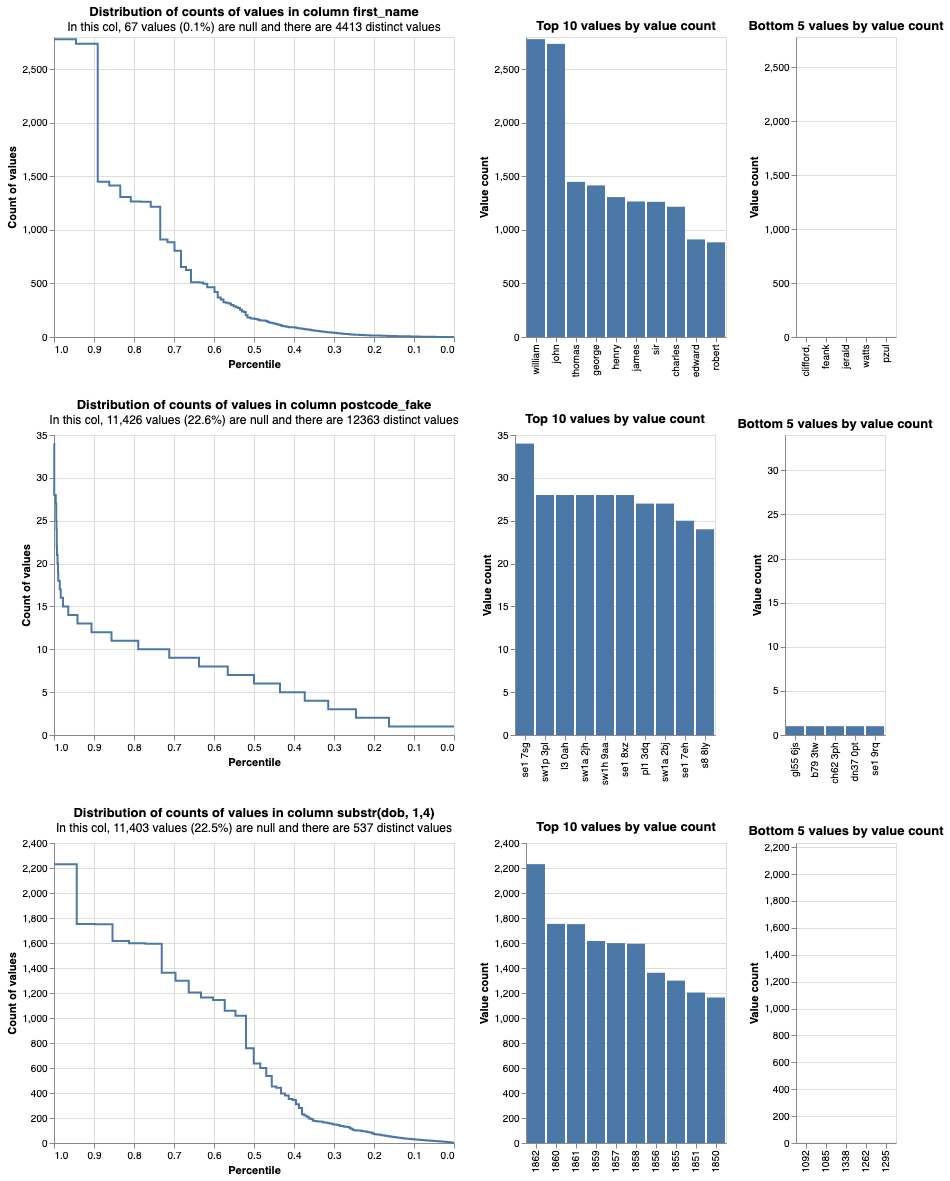

In [4]:
# Initialise the linker, passing in the input dataset(s)
linker = DuckDBLinker(df_clean, connection=":temporary:")

import altair as alt
alt.renderers.enable('mimetype')
linker.profile_columns(["first_name", "postcode_fake", "substr(dob, 1,4)"], top_n=10, bottom_n=5)

In [5]:
linker.compute_number_of_comparisons_generated_by_blocking_rule("l.first_name = r.first_name")

{'count_of_pairwise_comparisons_generated': 16372982}

In [6]:
linker.compute_number_of_comparisons_generated_by_blocking_rule("l.first_name = r.first_name and l.surname = r.surname",)

{'count_of_pairwise_comparisons_generated': 243656}

In [7]:
import splink.duckdb.duckdb_comparison_library as cl

settings = {
    "probability_two_random_records_match": 9/50_000,
    "link_type": "dedupe_only",
    "blocking_rules_to_generate_predictions": [
        "l.first_name = r.first_name and l.surname = r.surname",
        "l.surname = r.surname and l.dob = r.dob",
        "l.first_name = r.first_name and l.dob = r.dob",
        "l.postcode_fake = r.postcode_fake and l.first_name = r.first_name",
    ],
    "comparisons": [
        cl.jaccard_at_thresholds("first_name", [0.9, 0.5], term_frequency_adjustments=False),
        cl.jaccard_at_thresholds("surname", [0.9, 0.5], term_frequency_adjustments=False),
        cl.levenshtein_at_thresholds("dob", [1,2], term_frequency_adjustments=False),
        cl.levenshtein_at_thresholds("postcode_fake", 2),
        cl.exact_match("birth_place", term_frequency_adjustments=False),
        cl.exact_match("occupation",  term_frequency_adjustments=False),
    ],
    "retain_matching_columns": True,
    "retain_intermediate_calculation_columns": True,
    "max_iterations": 10,
    "em_convergence": 0.01
}

In [8]:
linker.initialise_settings(settings)

In [9]:
linker.estimate_u_using_random_sampling(target_rows=5e6)

----- Estimating u probabilities using random sampling -----

Estimated u probabilities using random sampling

Your model is not yet fully trained. Missing estimates for:
    - first_name (no m values are trained).
    - surname (no m values are trained).
    - dob (no m values are trained).
    - postcode_fake (no m values are trained).
    - birth_place (no m values are trained).
    - occupation (no m values are trained).



----- Starting EM training session -----

Estimating the m probabilities of the model by blocking on:
l.first_name = r.first_name and l.surname = r.surname

Parameter estimates will be made for the following comparison(s):
    - dob
    - postcode_fake
    - birth_place
    - occupation

Parameter estimates cannot be made for the following comparison(s) since they are used in the blocking rules: 
    - first_name
    - surname

Iteration 1: Largest change in params was -0.529 in probability_two_random_records_match
Iteration 2: Largest change in params was -0.037 in probability_two_random_records_match
Iteration 3: Largest change in params was 0.0162 in the m_probability of birth_place, level `Exact match`
Iteration 4: Largest change in params was -0.00771 in the m_probability of dob, level `All other comparisons`

EM converged after 4 iterations

Your model is not yet fully trained. Missing estimates for:
    - first_name (no m values are trained).
    - surname (no m values are trai

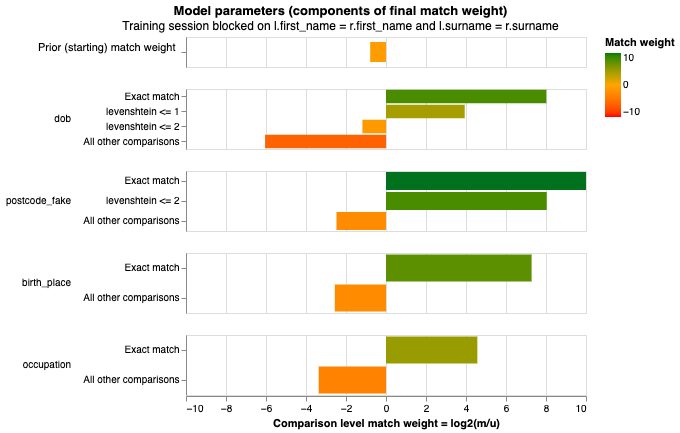

In [10]:
blocking_rule = "l.first_name = r.first_name and l.surname = r.surname"
training_session_names = linker.estimate_parameters_using_expectation_maximisation(blocking_rule)
training_session_names.match_weights_interactive_history_chart()


----- Starting EM training session -----

Estimating the m probabilities of the model by blocking on:
l.dob = r.dob

Parameter estimates will be made for the following comparison(s):
    - first_name
    - surname
    - postcode_fake
    - birth_place
    - occupation

Parameter estimates cannot be made for the following comparison(s) since they are used in the blocking rules: 
    - dob

Iteration 1: Largest change in params was -0.311 in the m_probability of first_name, level `Exact match`
Iteration 2: Largest change in params was -0.0718 in the m_probability of first_name, level `Exact match`
Iteration 3: Largest change in params was -0.0115 in the m_probability of surname, level `Exact match`
Iteration 4: Largest change in params was -0.00288 in the m_probability of surname, level `Exact match`

EM converged after 4 iterations

Your model is fully trained. All comparisons have at least one estimate for their m and u values


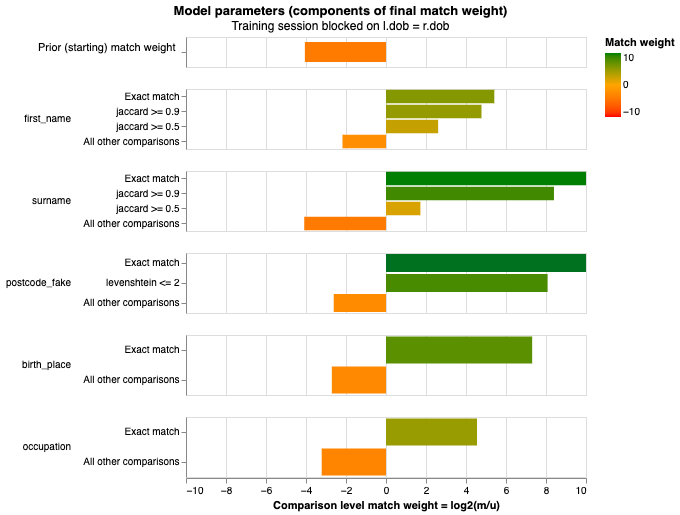

In [11]:
blocking_rule = "l.dob = r.dob"
training_session_dob = linker.estimate_parameters_using_expectation_maximisation(blocking_rule)
training_session_dob.match_weights_interactive_history_chart()

The final match weights can be viewed in the match weights chart:

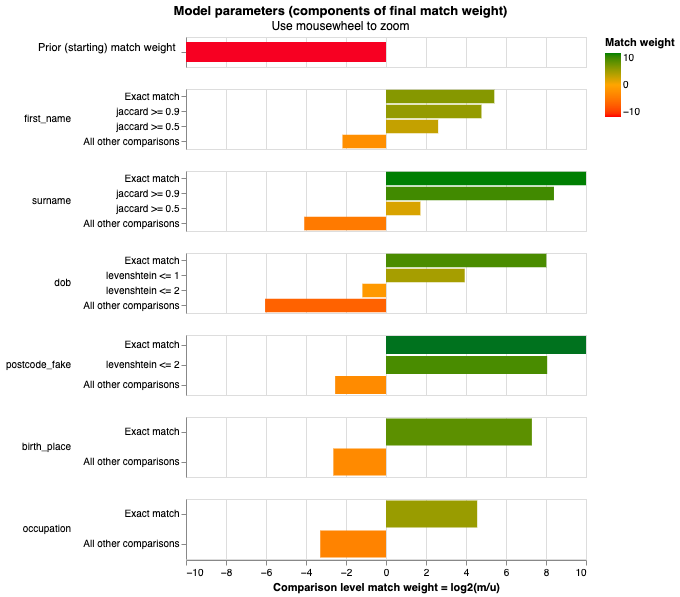

In [12]:
linker.match_weights_chart()

In [13]:
df_e = linker.predict().as_pandas_dataframe(limit=20)

df_e.head()

,match_weight,match_probability,unique_id_l,unique_id_r,first_name_l,first_name_r,gamma_first_name,bf_first_name,surname_l,surname_r,...,bf_postcode_fake,birth_place_l,birth_place_r,gamma_birth_place,bf_birth_place,occupation_l,occupation_r,gamma_occupation,bf_occupation,match_key
0,16.688616,0.999991,Q2296770-1,Q2296770-14,thomas,thomas,3,42.672785,chudleigh,chudleigh,...,266.680844,devon,NaN,-1,1.000000,politician,politician,1,23.574636,0
1,2.151050,0.816227,Q2296770-10,Q2296770-14,thomas,thomas,3,42.672785,chudleigh,chudleigh,...,0.171590,devon,NaN,-1,1.000000,politician,politician,1,23.574636,0
2,22.245485,1.000000,Q1443188-1,Q1443188-3,frank,frank,3,42.672785,brightman,brightman,...,4598.573173,bristol,"bristol, city of",0,0.161302,liturgist,liturgist,1,23.574636,0
3,22.245485,1.000000,Q1443188-2,Q1443188-3,frank,frank,3,42.672785,brightman,brightman,...,4598.573173,bristol,"bristol, city of",0,0.161302,liturgist,liturgist,1,23.574636,0
4,6.086680,0.985499,Q1443188-4,Q1443188-5,francis,francis,3,42.672785,brightman,brightman,...,0.171590,NaN,"bristol, city of",-1,1.000000,liturgist,liturgist,1,23.574636,0


You can also view rows in this dataset as a waterfall chart as follows:

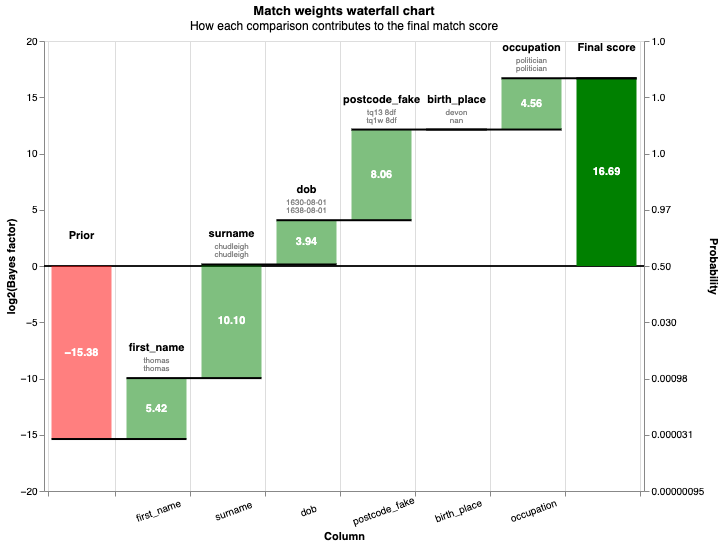

In [14]:
from splink.charts import waterfall_chart
records_to_plot = df_e.to_dict(orient="records")
linker.waterfall_chart(records_to_plot, filter_nulls=False)